In [1]:
# 소프트웨어 에서의 디자인 패턴 : 특정 환경에서 반복되는 문제들을 재사용할 수 있는 방법으로 해결한 것

# 디자인 패턴은 크게 생성, 구조, 행동 패턴으로 나뉜다.

# 이 분야의 고전인 GoF 의 디자인 패턴 에는 이와 관련된 23개의 패턴이 정리되어 있다.

# 안타깝게도, 스몰토크나 C++ 을 바탕으로 한 구현코드는 파이썬과 같은 동적 언어에서는 부합하지 않는다.
# (23개 중 16개가 동적 언어에서는 보이지 않거나 더 단순하다고 한다)

# 여기선 행동 패턴의 하나인 전략 패턴을 고전적인 방식에서부터 파이썬에 맞는 방식으로 변형시켜가며 동적 언어에서 구현체의 차이점을 살펴보고자 한다

In [ ]:
# 8퍼센트 마켓은 다음과 같은 할인 규칙을 가지고 있다

# 충성도 포인트가 1000 점 이상인 고객은 전체 주문에 대해 5 % 할인을 적용한다.
# 하나의 주문에서 20 개 이상의 상품을 구입하면 해당 상품에 대해 10 % 할인을 적용한다.
# 서로 다른 상품을 10 가지 이상 주문하면 전체 주문에 대해 7 % 할인을 적용한다.

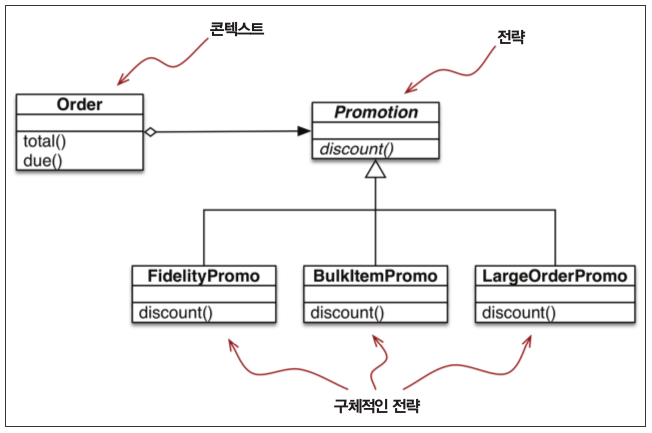

In [1]:
# 전략 패턴 UML 클래스 다이어그램
from IPython.display import Image
Image(filename='file/strategy_uml.png')

In [2]:
# 콘텍스트
# 일부 계산을 서로 다른 알고리즘을 구현하는 교환 가능한 컴포넌트에 위임함으로써 서비스를 제공한다. 
# 전자상거래 예제에서 콘텍스트는 Order 로서, 여러 알고리즘 중 하나에 따라 프로모션 할인을 적용하도록 설정된다.

# 전략
# 여러 알고리즘을 구현하는 컴포넌트에 공통된 인터페이스. 전자상거래 예제에서 이 역할은 Promotion 이라는 추상 클래스가 담당한다.

# 구체적인 전략
# 전략의 구상 서브클래스 중 하나. 여기서는 FidelityPromo , BulkItemPromo , LargeOrderPromo 등 총 3 개의 구체적인 전략이 구현되어 있다.

In [2]:
# 6-1 플러그인 형 할인 전략을 가진 Order 클래스 구현

In [3]:
from abc import ABC, abstractmethod
from collections import namedtuple

Customer = namedtuple('Customer', 'name fidelity')


class LineItem:
    """장바구니 클래스"""
    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price

    def total(self):
        return self.price * self.quantity

    
# 콘텍스트
class Order:
    """주문 클래스"""
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = list(cart)
        self.promotion = promotion
    
    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total
    
    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion.discount(self)
        return self.total() - discount

    def __repr__(self):
        fmt = '<Order total: {:.2f} due: {:.2f}>'
        return fmt.format(self.total(), self.due())
    
    
# 전략
class Promotion(ABC):
    """전략패턴을 위한 Abstract Base Class"""
    @abstractmethod
    def discount(self, order):
        """할인액을 구체적인 숫자로 반환한다."""

        
# 첫번째 구체적인 전략
class FidelityPromo(Promotion):
    """충성도 포인트가 1000점 이상인 고객에게 전체 5% 할인 적용"""
    def discount(self, order):
        return order.total() * .05 if order.customer.fidelity >= 1000 else 0


# 두번째 구체적인 전략
class Bulkitemromo(Promotion):
    """20개 이상의 동일 상품을 구입하면 10% 할인 적용"""
    def discount(self, order):
        discount = 0
        for item in order.cart:
            if item.quantity >= 20:
                discount += item.total() * .1
        return discount


# 세번째 구체적인 전략
class LargeOrderPromo(Promotion):
    """10 종류 이상의 상품을 구입하면 전체 7% 할인 적용"""
    def discount(self, order):
        discount = 0
        distinct_tems = {item.product for item in order.cart}
        if len(distinct_tems) >= 10:
            return order.total() * .07
        return 0

In [4]:
# 6-2 사용예

In [5]:
"""
존의 충성도는 0, 앤은 1100이다. 
카트목록은 총 3개이다
바나나의 수량은 4, 가격은 5 이다
사과의 수량은 10, 가격은 1.5 이다
수박의 수량은 5, 가격은 5 이다
"""
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)
cart = [LineItem('banana', 4, 5), LineItem('apple', 10, 1.5), LineItem('watermelon', 5, 5.0)]

In [6]:
# 충성도 포인트
Order(joe, cart, FidelityPromo())

<Order total: 60.00 due: 60.00>

In [7]:
# 충성도 포인트
Order(ann, cart, FidelityPromo())

<Order total: 60.00 due: 57.00>

In [31]:
# 새로운 카트 - 대량구매
banana_cart = [LineItem('banana', 30, .5), LineItem('apple', 10, 1.5)]

In [32]:
# 동일 상품
Order(joe, banana_cart, Bulkitemromo())

<Order total: 30.00 due: 28.50>

In [33]:
# 새로운 카트 - 다품종 구매
long_order = [LineItem(str(item_code), 1, 1.0) for item_code in range(10)]

In [34]:
# 다품종
Order(joe, long_order, LargeOrderPromo())

<Order total: 10.00 due: 9.30>

In [38]:
# 다품종
Order(joe, cart, LargeOrderPromo())

<Order total: 60.00 due: 60.00>

In [39]:
# 6-3 할인 전략을 함수로 구현
# 위에서 살펴본 전략 패턴은 discount 함수를 가진 클래스로 구성된다
# 객체의 속성이 없는 관계로 일반 함수로 구성하면 더 단순화 시킬 수 있다

In [ ]:
# 파이썬의 함수는 일급 객체 (Fluent Python 5장 참고)

# 일급 객체의 정의

# 1. 실행시 생성할 수 있다
# 2. 데이터 구조체의 변수나 요소에 할당될 수 있다
# 3. 함수 인자로 전달될 수 있다
# 4. 함수 결과로 반환할 수 있다

In [40]:
from collections import namedtuple

Customer = namedtuple('Customer', 'name fidelity')


class LineItem:
    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price

    def total(self):
        return self.price * self.quantity

    
class Order: # 콘텍스트
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = list(cart)
        self.promotion = promotion
        
    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total

    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion(self)
        return self.total() - discount

    def __repr__(self):
        fmt = ' < Order total: {:.2f} due: {:.2f} > '
        return fmt.format(self.total(), self.due())

    
# 추상 클래스와 추상 메소드가 사라지고, 전략패턴의 클래스를 함수로 구현했다
def fidelity_promo(order): 
    """ 충성도 포인트가 1000 점 이상인 고객에게 전체 5% 할인 적용 """
    return order.total() * .05 if order.customer.fidelity >= 1000 else 0


def bulk_item_promo(order):
    """20 개 이상의 동일 상품을 구입하면 10% 할인 적용 """
    discount = 0
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * .1
    return discount


def large_order_promo(order):
    """10 종류 이상의 상품을 구입하면 전체 7% 할인 적용 """
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * .07
    return 0

In [41]:
# 6-4 할인 전략을 함수로 정의한 Order 클래스의 사용 예

In [42]:
joe = Customer('John Doe', 0) 
ann = Customer('Ann Smith', 1100)

In [43]:
joe

Customer(name='John Doe', fidelity=0)

In [44]:
cart = [LineItem('banana', 4, .5), LineItem('apple', 10, 1.5), LineItem('watermellon', 5, 5.0)]

In [45]:
Order(joe, cart, fidelity_promo)

 < Order total: 42.00 due: 42.00 > 

In [46]:
Order(ann, cart, fidelity_promo)

 < Order total: 42.00 due: 39.90 > 

In [47]:
banana_cart = [LineItem('banana', 30, .5), LineItem('apple', 10, 1.5)]

In [48]:
# 대량구매
Order(joe, banana_cart, bulk_item_promo)

 < Order total: 30.00 due: 28.50 > 

In [49]:
long_order = [LineItem(str(item_code), 1, 1.0) for item_code in range(10)]

In [50]:
#다품종 구매
Order(joe, long_order, large_order_promo)

 < Order total: 10.00 due: 9.30 > 

In [51]:
Order(joe, cart, large_order_promo)

 < Order total: 42.00 due: 42.00 > 

In [25]:
# 최선의 전략 선택하려면?

In [26]:
# 6-6 리스트를 사용한 단순한 접근

In [41]:
promos = [fidelity_promo, bulk_item_promo, large_order_promo]

In [42]:
def best_promo(order): 
    """ 최대로 할인받을 금액을 반환한다"""
    return max(promo(order) for promo in promos)

In [43]:
best_promo(Order(joe, banana_cart))

1.5

In [52]:
# 6-7 모듈 전역 네임스페이스를 내부 조사해서 만든 promos 리스트

# 새로운 할인 전략이 추가된다면? (리스트에 추가를 안해줬다면?)

# globals() : 현재 전역 심벌 테이블을 나타내는 딕셔너리 객체를 반환한다
# 이 딕셔너리는 언제나 현재 모듈에 대한 내용을 담고 있다
# https://docs.python.org/3/library/functions.html#globals

In [30]:
globals()

{'ABC': abc.ABC,
 'Bulkitemromo': __main__.Bulkitemromo,
 'Customer': __main__.Customer,
 'FidelityPromo': __main__.FidelityPromo,
 'In': ['',
  '# fluent python 6',
  '# 6-1',
  '# 플러그인 형 할인 전략을 가진 Order 클래스 구현\n\nfrom abc import ABC, abstractmethod\nfrom collections import namedtuple\n\nCustomer = namedtuple(\'Customer\', \'name fidelity\')\n\n\nclass LineItem:\n    \n    def __init__(self, product, quantity, price):\n        self.product = product\n        self.quantity = quantity\n        self.price = price\n\n    def total(self):\n        return self.price * self.quantity\n\n    \n# 콘텍스트\nclass Order:\n    \n    def __init__(self, customer, cart, promotion=None):\n        self.customer = customer\n        self.cart = list(cart)\n        self.promotion = promotion\n    \n    def total(self):\n        if not hasattr(self, \'__total\'):\n            self.__total = sum(item.total() for item in self.cart)\n        return self.__total\n    \n    def due(self):\n        if self.promotion

In [53]:
# 무한재귀호출을 피하기 위해 best_promo 를 제외한 _promo 로 끝나는 이름의 리스트를 만든다.
promos = [globals()[name] for name in globals() if name.endswith('_promo') and name != 'best_promo']

In [54]:
promos

[<function __main__.bulk_item_promo>,
 <function __main__.fidelity_promo>,
 <function __main__.large_order_promo>]

In [55]:
def best_promo(order):
    """ 최대로 할인받을 금액을 반환한다"""
    return max(promo(order) for promo in promos)

In [57]:
# 동작은 하지만 global() 을 사용하는 것이 무겁게 느껴지고, 파라미터가 다른 함수 중에 _promo 를 포함한 이름이 추가된 경우 수정이 불가피하다
best_promo(Order(joe, banana_cart))

1.5

In [51]:
# 6-8 새로운 promotions 모듈을 내부 조사해서 만든 promos 리스트

In [59]:
import inspect
import promotions  # 할인액 계산을 위한 함수들을 모은 모듈

In [60]:
inspect.getmembers(promotions, inspect.isfunction)

[('bulk_item_promo', <function promotions.bulk_item_promo>),
 ('fidelity_promo', <function promotions.fidelity_promo>),
 ('large_order_promo', <function promotions.large_order_promo>)]

In [63]:
promos = [func for name, func in inspect.getmembers(promotions, inspect.isfunction)]

In [64]:
promos

[<function promotions.bulk_item_promo>,
 <function promotions.fidelity_promo>,
 <function promotions.large_order_promo>]

In [65]:
def best_promo(order):
    """ 최대로 할인받을 금액을 반환한다"""
    return max(promo(order) for promo in promos)

In [66]:
best_promo(Order(joe, banana_cart))

1.5

In [ ]:
# 7장 데커레이터로 개선한 전략  패턴

In [128]:
from collections import namedtuple
Customer = namedtuple('Customer', 'name fidelity')

In [67]:
# 콘텍스트
class Order:
    
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = list(cart)
        self.promotion = promotion
    
    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total
    
    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion.discount(self)
        return self.total() - discount

    def __repr__(self):
        fmt = '<Order total: {:.2f} due: {:.2f}>'
        return fmt.format(self.total(), self.due())

In [78]:
promos = []

In [79]:
def promotion(promo_func):
    promos.append(promo_func)
    return promo_func

In [80]:
@promotion
def fidelity(order):
    """ 충성도 포인트가 1000 점 이상인 고객에게 전체 5% 할인 적용 """
    return order.total() * .05 if order.customer.fidelity >= 1000 else 0

@promotion
def bulk_item(order):
    """20 개 이상의 동일 상품을 구입하면 10% 할인 적용 """
    discount = 0
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * .1
    return discount

@promotion
def large_order(order):
    """10 종류 이상의 상품을 구입하면 전체 7% 할인 적용 """
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * .07
    return 0

def list_promo(order):
    """프로모션 별 할인금액 리스트를 구한다"""
    return [(promo, promo(order)) for promo in promos]

def best_promo(order):
    """최대로 할인받을 금액을 반환한다"""
    return max(promo(order) for promo in promos)

In [81]:
promos

[<function __main__.fidelity>,
 <function __main__.bulk_item>,
 <function __main__.large_order>]

In [82]:
best_promo(Order(joe, banana_cart))

1.5

In [83]:
list_promo(Order(joe, banana_cart))

[(<function __main__.fidelity>, 0),
 (<function __main__.bulk_item>, 1.5),
 (<function __main__.large_order>, 0)]

In [10]:
# 참고자료

In [9]:
import webbrowser

# 파이썬3 패턴관련 사이트
url = 'http://python-3-patterns-idioms-test.readthedocs.io/en/latest/PatternConcept.html'
webbrowser.open(url)

True

In [11]:
# 동적 언어에서의 디자인 패턴
url = 'http://norvig.com/design-patterns/design-patterns.pdf'
webbrowser.open(url)

True